In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install mahanlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 119.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [4]:
from mahaNLP.preprocess import Preprocess

model2 = Preprocess()

import re

def remove_nondevnagari(text):
    return re.sub(r'[^\u0900-\u097F\s]', '', text)

'''
text5 = 'डाळी भारतीय थाळीमध्ये सामील असलेले मुख्य भोजन आहेत. US agriculture department, यु एस एग्रीकल्चर डिपार्टमेंट नुसार १०० ग्रॅम डाळ मध्ये 8 ते 9 ग्राम प्रोटीन असतात.'

remove_nondevnagari(text5)
output -
'डाळी भारतीय थाळीमध्ये सामील असलेले मुख्य भोजन आहेत    यु एस एग्रीकल्चर डिपार्टमेंट नुसार १०० ग्रॅम डाळ मध्ये  ते  ग्राम प्रोटीन असतात'
'''


def preprocess_text(text):
    text = model2.remove_url(text)
    text = ' '.join(model2.remove_stopwords(text))
    text = remove_nondevnagari(text)
    return text



In [5]:
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_df = pd.read_csv(r'/content/drive/My Drive/bert_data/marathi_train.csv')
val_df = pd.read_csv(r'/content/drive/My Drive/bert_data/marathi_val.csv')
test_df = pd.read_csv(r'/content/drive/My Drive/bert_data/marathi_test.csv')

train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

def preprocess_df(df):
    df = df.drop('uid', axis=1)
    df.columns = ['Text', 'Type']
    return df
train_df = preprocess_df(train_df)
val_df = preprocess_df(val_df)
test_df = preprocess_df(test_df)

X_train = list(train_df['Text'].values)
y_train = list(train_df['Type'].values)

X_valid = list(val_df['Text'].values)
y_valid = list(val_df['Type'].values)

X_test = list(test_df['Text'].values)
y_test = list(test_df['Type'].values)

In [7]:
tokenizer = BertTokenizer.from_pretrained("l3cube-pune/mahahate-bert")


In [8]:
def generate_dataset(X, y, tokenizer):
    encodings = tokenizer.batch_encode_plus(X,
                                           truncation=True,
                                           padding=True,
                                           max_length=128,
                                           return_tensors='pt',
                                           add_special_tokens=True)

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    y = torch.tensor(y)
    dataset = TensorDataset(input_ids, attention_mask, y)
    return dataset
train_dataset = generate_dataset(X_train, y_train, tokenizer)
valid_dataset = generate_dataset(X_valid, y_valid, tokenizer)


In [9]:
def get_data_loader(dataset, sampler):
    return DataLoader(dataset=dataset, sampler=sampler(dataset), batch_size=32)

train_loader = get_data_loader(train_dataset, RandomSampler)
validation_loader = get_data_loader(valid_dataset, SequentialSampler)


In [10]:
model = BertForSequenceClassification.from_pretrained("l3cube-pune/mahahate-bert", num_labels=2)
model.to(device)
print("Imported model!")

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

Imported model!


In [11]:
num_epochs = 8
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def compute_accuracy(preds, labels):
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [12]:
# Train function remains the same
def train():
    total_loss = 0.0
    total_acc = 0.0
    model.train()
    for step, batch in enumerate(train_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    return avg_loss, avg_acc

# Evaluation function remains the same
def evaluate():
    total_loss = 0.0
    total_acc = 0.0
    model.eval()  # Switch model to evaluation mode
    true_labels = []
    predictions = []

    for step, batch in enumerate(validation_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits, axis=1).flatten()
        labels = labels.detach().cpu().numpy().flatten()

        true_labels.extend(labels)
        predictions.extend(logits)

    avg_loss = total_loss / len(validation_loader)
    avg_acc = total_acc / len(validation_loader)
    macro_f1_score = classification_report(true_labels, predictions, output_dict=True)['macro avg']['f1-score']

    return avg_loss, avg_acc, macro_f1_score

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0

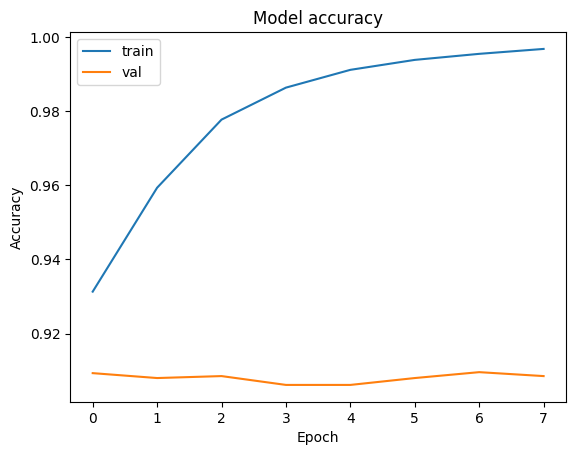

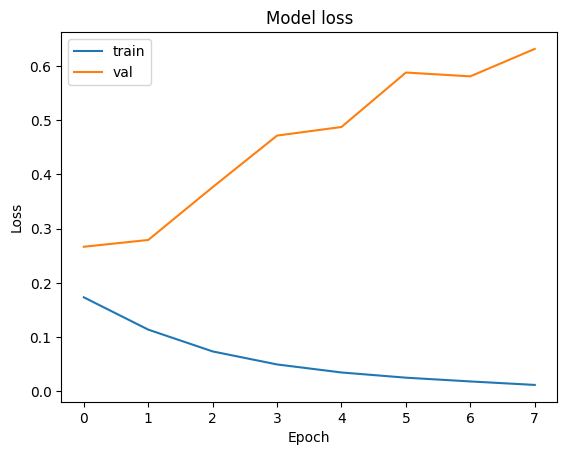

In [13]:
import os
# Initialize the lists
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# Define paths
model_path = '/content/drive/My Drive/bert_data/marathi_bert_model.pt'
metrics_path = '/content/drive/My Drive/bert_data/metrics.pt'

# Check if model and metrics file exists in the specified Google Drive path
if os.path.exists(model_path) and os.path.exists(metrics_path):
    metrics = torch.load(metrics_path)
    train_losses = metrics['train_losses']
    train_accs = metrics['train_accs']
    valid_losses = metrics['valid_losses']
    valid_accs = metrics['valid_accs']

else:
    best_f1 = 0
    for epoch in range(num_epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
        train_loss, train_acc = train()
        valid_loss, valid_acc, f1_score = evaluate()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if f1_score > best_f1:
            best_f1 = f1_score
            torch.save(model, model_path)

        print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f}')

    # Save the metrics
    metrics = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'valid_losses': valid_losses,
        'valid_accs': valid_accs,
    }
    torch.save(metrics, metrics_path)


import matplotlib.pyplot as plt

plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




In [14]:
load_path = '/content/drive/My Drive/bert_data/marathi_bert_model.pt'  # TODO: Update this to your path
model = torch.load(load_path)
model = model.to(device)

In [15]:
test_dataset = generate_dataset(X_test, y_test, tokenizer)
test_loader = get_data_loader(test_dataset, SequentialSampler)

# Test evaluation function
def test_evaluate():
    total_loss = 0.0
    total_acc = 0.0
    model.eval()  # Switch model to evaluation mode
    true_labels = []
    predictions = []

    for step, batch in enumerate(test_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits, axis=1).flatten()
        labels = labels.detach().cpu().numpy().flatten()

        true_labels.extend(labels)
        predictions.extend(logits)

    avg_loss = total_loss / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    macro_f1_score = classification_report(true_labels, predictions, output_dict=True)['macro avg']['f1-score']

    return avg_loss, avg_acc, macro_f1_score

# Run the test evaluation
test_loss, test_acc, f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f}')

  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Test Accuracy: 0.933 | Test Loss: 0.425 | F1 Score: 0.933


In [16]:
l3cube_df =  pd.read_csv(r'/content/drive/My Drive/bert_data/l3cube_mr_test.csv')
l3cube_df['text'] = l3cube_df['text'].apply(preprocess_text)
l3cube_df = preprocess_df(l3cube_df)

X3_test = list(l3cube_df['Text'].values)
y3_test = list(l3cube_df['Type'].values)


test_dataset = generate_dataset(X3_test, y3_test, tokenizer)
test_loader = get_data_loader(test_dataset, SequentialSampler)

test_loss, test_acc, f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f}')

  Batch    50  of    118.
  Batch   100  of    118.

Test Accuracy: 0.911 | Test Loss: 0.563 | F1 Score: 0.912
